<a class="anchor" id="0."></a>
# Content

* [1. Summary](#1.)
* [2. Cats and Dogs Dataset](#2.)
* * [2.1. Randomly Visualization of Samples in the Dataset](#2.1.)
* * [2.2. Some Evaluations About the Dataset](#2.2.)
* [3. Convolutional Neural Network(CNN)](#3.)
* * [3.1. Implementing CNN Architecture with Keras](#3.1.)
* [4.Transfer Learning 1: Feature Extractor](#4.)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os
print("Cats&Dogs Dataset Folder Contain:",os.listdir("../input"))

Using TensorFlow backend.


Cats&Dogs Dataset Folder Contain: ['test1.zip', 'train.zip', 'sampleSubmission.csv']


[Go to Content Menu](#0.)

# <a class="anchor" id="1."></a>1. Summary

In this study, CNN architecture and transfer learning techniques will be used to classify cats and dogs in the Cats & Dogs dataset. Firstly, the dataset will be visualized and evaluated. Then, a CNN architecture will be created with keras, and trained and estimated on training and test sets respectively.  Then transfer learning technques will be applied on the dataset. 

Transfer learning is one of the important advantages of deep learning. There are two different transfer learning types used on image data; feature extractor and fine tunning. In this kernel transfer learning used as feature extractor on the Cats & Dogs dataset.

In this study you will learn:

* Visualization of images in form of gallery
* Use of CNN architecture in image classification.
* Transfer Learning Type 1-Feature Extractor : pretrained model used such as feature extractor.

Accuracy performace of the approaches as follows:

* Custom CNN accurcy rate is %80(+-2)
* Transfer Learning Type 1-Feature Extractor accuracy rate is %95(+-1)

[Go to Content Menu](#0.)

# <a class="anchor" id="2."></a>2. Cats and Dogs Dataset

The dataset provide 25000 cats and dogs images to classify. Samples of the dataset as in form image gallery can be seen in figures in the next section. 

[Go to Content Menu](#0.)

# <a class="anchor" id="2.1."></a>2.1. Randomly Visualization of Samples in the Dataset


In [2]:
import zipfile


zip_files = ['test1', 'train']
# Will unzip the files so that you can see them..
for zip_file in zip_files:
    with zipfile.ZipFile("../input/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [3]:
print(os.listdir('../input'))

['test1.zip', 'train.zip', 'sampleSubmission.csv']


In [4]:
IMAGE_FOLDER_PATH="../working/train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

In [5]:
targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset=pd.DataFrame()
dataset['image_path']=full_paths
dataset['target']=targets

In [6]:
dataset.head(10)

,image_path,target
0,../working/train/cat.6731.jpg,cat
1,../working/train/cat.6796.jpg,cat
2,../working/train/dog.3182.jpg,dog
3,../working/train/cat.10964.jpg,cat
4,../working/train/dog.6820.jpg,dog
5,../working/train/cat.7806.jpg,cat
6,../working/train/cat.11216.jpg,cat
7,../working/train/cat.8308.jpg,cat
8,../working/train/dog.9934.jpg,dog
9,../working/train/cat.10132.jpg,cat


In [7]:
target_counts=dataset['target'].value_counts()
print("Number of dogs in the dataset:{}".format(target_counts['dog']))
print("Number of cats in the dataset:{}".format(target_counts['cat']))

Number of dogs in the dataset:12500
Number of cats in the dataset:12500


In [8]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="both"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(targets)
    for path, target in zip(full_paths, targets):
        if target!=show and show!="both":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(WIDTH,HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title={"both":"Dogs and Cats",
          "cat": "Cats",
          "dog": "Dogs"}
    plt.title("100 samples of {} of the dataset".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

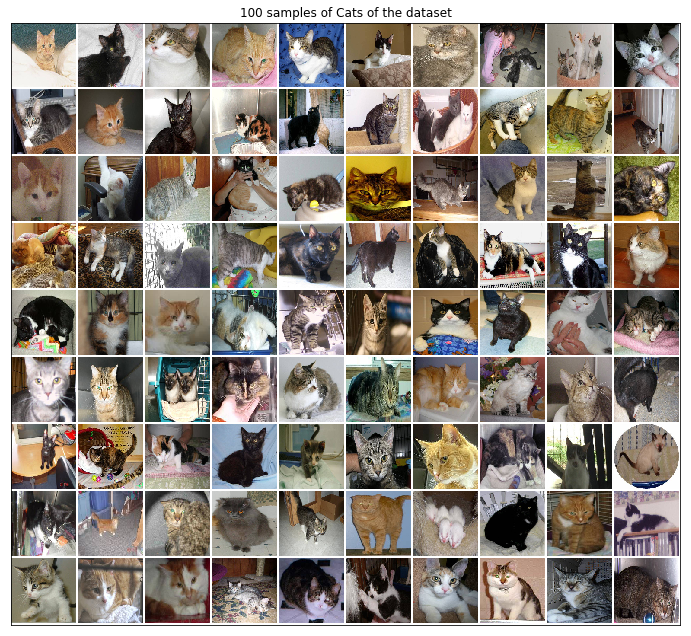

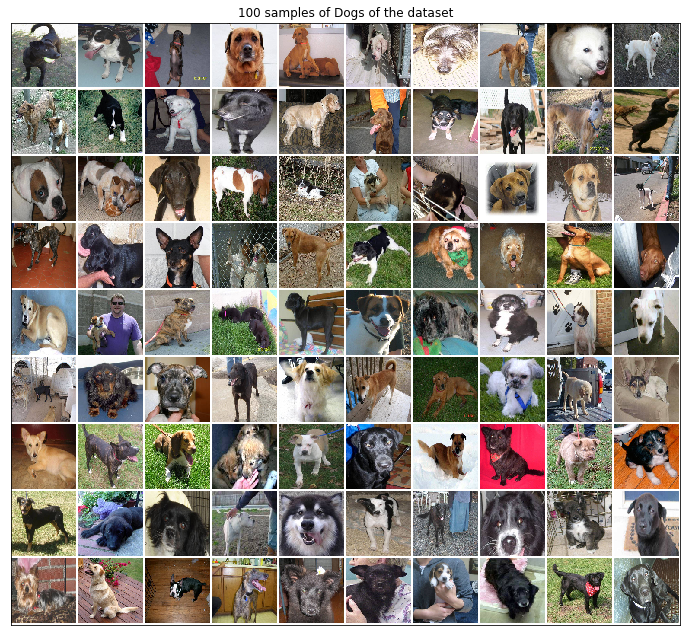

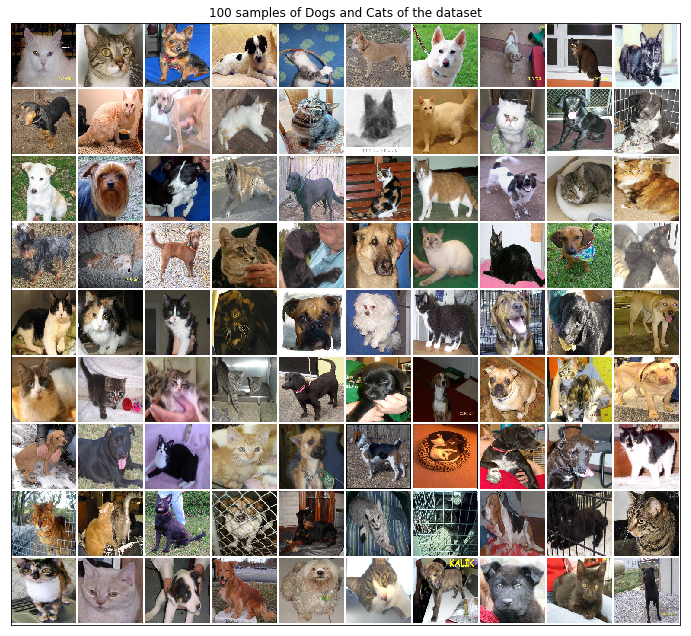

In [9]:
show_gallery(show="cat")
show_gallery(show="dog")
show_gallery(show="both")

[Go to Content Menu](#0.)

# <a class="anchor" id="2.1."></a>2.2. Some Evaluations About the Dataset
There are  three image galleries in above figures. First one showing only images of cats, second one showing only images of dogs and third one shows images of cats and dogs.  When the images in galleries are examined, it is possible to make the following evaluations;



* There are many different types of cats
* There are many different types of dogs
* Some cat (dog) breeds are very similar to some dog (cat) breeds.
* The backgrounds in the images are very different and noisy.
* The difference in exposure of cats and dogs in the images is quite high.

The above features have the effect of making image classification difficult. In addition, the difference in light that makes image classification difficult, is little to be ignored.

[Go to Content Menu](#0.)

# <a class="anchor" id="."></a>3. Convolutional Neural Network(CNN)



In [10]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validatin Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history["Validatin Accuracy"]=modelHistory.history['val_accuracy']
  
    history.plot(figsize=(12,8))
    plt.title(" Convulutional Model {} Train and Validation Loss and Accuracy History".format(model_name))
    plt.show()

[Go to Content Menu](#0.)

# <a class="anchor" id="3.1."></a>3.1. Implementing CNN Architecture with Keras

In [11]:
model=models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 64)       

In [12]:
model.compile(loss="binary_crossentropy", 
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=["accuracy"])
print("[INFO]: model compiled...")

[INFO]: model compiled...


In [13]:
dataset_train, dataset_test=train_test_split(dataset,
                                                 test_size=0.2,
                                                 random_state=42)

In [14]:
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_test,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
modelHistory=model.fit_generator(train_datagenerator,
                                epochs=50,
                                validation_data=test_datagenerator,
                                validation_steps=dataset_test.shape[0]//150,
                                steps_per_epoch=dataset_train.shape[0]//150
                                )

Epoch 1/50
133/133 [==============================] - 171s 1s/step - loss: 0.9673 - accuracy: 0.5492 - val_loss: 0.8345 - val_accuracy: 0.5081
Epoch 2/50
133/133 [==============================] - 168s 1s/step - loss: 0.7014 - accuracy: 0.5960 - val_loss: 1.4210 - val_accuracy: 0.5076
Epoch 3/50
133/133 [==============================] - 167s 1s/step - loss: 0.6553 - accuracy: 0.6180 - val_loss: 2.1587 - val_accuracy: 0.5105
Epoch 4/50
133/133 [==============================] - 169s 1s/step - loss: 0.6213 - accuracy: 0.6573 - val_loss: 1.2893 - val_accuracy: 0.5371
Epoch 5/50
133/133 [==============================] - 167s 1s/step - loss: 0.5917 - accuracy: 0.6858 - val_loss: 1.0948 - val_accuracy: 0.6303
Epoch 6/50
133/133 [==============================] - 167s 1s/step - loss: 0.5659 - accuracy: 0.7044 - val_loss: 0.6668 - val_accuracy: 0.6619
Epoch 7/50
133/133 [==============================] - 167s 1s/step - loss: 0.5441 - accuracy: 0.7246 - val_loss: 0.8155 - val_accuracy: 0.7089

Train Accuracy:0.913
Test Accuracy:0.900


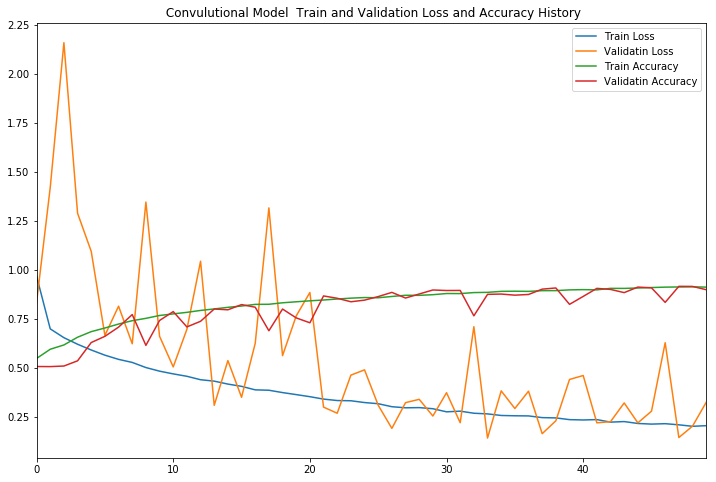

In [17]:
print("Train Accuracy:{:.3f}".format(modelHistory.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(modelHistory.history['val_accuracy'][-1]))
show_model_history(modelHistory=modelHistory, model_name="")

[Go to Content Menu](#0.)

# <a class="anchor" id="4."></a>4.Transfer Learning 1: Feature Extractor

In this section and in the next section, the use of  pretrained model on a dataset, on another dataset will be explained.

In traditional computer vision approaches, feature vectors are extracted from the images in the dataset, and these features are classified by supervised machine learning algorithms. In CNN deep learning approaches, images are given to the CNN model, which makes classification without feature extraction process. 

The only advantage of deep learning is not to make classification without using feature extractor. CNN also allows for the use of pretrained models on new datasets. This approach is called Transfer Learning. There are two different Transfer Learning approaches;

* Feature Extractor
* Fine Tunning

Transfer learning is based on the paradigm where a model previously trained on the A dataset can be used as a starting point on the B dataset. For example, a model that is trained for classification on snake and frog dataset can be used as a starting point for the classification of bear, panda and deer dataset. This can be thought of as how to find models that have been previously trained on the appropriate dataset. The models of the CNN architectures, which are featured in the image classification, are trained on "ImageNet" and are available in the keras library. These architectures can be easily used for the purpose of transfer learning on new datasets.

In [18]:
model=applications.VGG16(weights="imagenet", include_top=False, input_shape=(WIDTH, HEIGHT, 3))
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

Since the last layer (4,4,512) is in dimensions, the length of the feature vector will be 4x4x512 = 8192.

In [34]:
full_paths[:6]

['../working/train/cat.5938.jpg',
 '../working/train/cat.2254.jpg',
 '../working/train/dog.6404.jpg',
 '../working/train/dog.10474.jpg',
 '../working/train/cat.1917.jpg',
 '../working/train/dog.3412.jpg']

In [39]:
targets[:6]

array([0, 0, 1, 1, 0, 1])

In [19]:
counter=0
features=list()
for path, target in zip(full_paths, targets):
    img=load_img(path, target_size=(WIDTH, HEIGHT))
    img=img_to_array(img)
    img=np.expand_dims(img, axis=0)
    feature=model.predict(img)
    features.append(feature)
    counter+=1
    if counter%2500==0:
        print("[INFO]:{} images loaded".format(counter))



[INFO]:2500 images loaded
[INFO]:5000 images loaded
[INFO]:7500 images loaded
[INFO]:10000 images loaded
[INFO]:12500 images loaded
[INFO]:15000 images loaded
[INFO]:17500 images loaded
[INFO]:20000 images loaded
[INFO]:22500 images loaded
[INFO]:25000 images loaded


In [20]:
features=np.array(features)
print("Before reshape,features.shape:",features.shape)
features=features.reshape(features.shape[0], 4*4*512)
print("After reshape, features.shape:",features.shape)

Before reshape,features.shape: (25000, 1, 4, 4, 512)
After reshape, features.shape: (25000, 8192)


In [21]:
le=LabelEncoder()
targets=le.fit_transform(targets)

In [22]:
print("features.shape:",features.shape)
print("targets.shape:",targets.shape)

features.shape: (25000, 8192)
targets.shape: (25000,)


In [23]:
X_train, X_test, y_train, y_test=train_test_split(features, targets, test_size=0.2, random_state=42)

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
clf=LogisticRegression(solver="lbfgs")
print("{} training...".format(clf.__class__.__name__))
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("The model trained and used to predict the test data...")

LogisticRegression training...
The model trained and used to predict the test data...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, y_pred))
print("Classification Report:\n",metrics.classification_report(y_test, y_pred, target_names=["cat", "dog"]))

Accuracy: 0.9412
Confusion Matrix:
 [[2348  144]
 [ 150 2358]]
Classification Report:
               precision    recall  f1-score   support

         cat       0.94      0.94      0.94      2492
         dog       0.94      0.94      0.94      2508

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



In [30]:
metrics.roc_auc_score(y_test, y_pred)

0.9412032379211563

In [32]:
metrics.f1_score(y_test, y_pred, average = 'weighted')

0.9412001411205645

Notice here that we are able to reach 94% classification accuracy! This number is a massive improvement from our previous best of 80% in our custom CNN model. 

Let's find cross validated score for more trusted model. 

In [27]:
cv_scores=cross_val_score(LogisticRegression(solver="lbfgs"), features, targets, cv=3 )
print("Cross validation scores obtained...")

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Cross validation scores obtained...


In [28]:
print("Cross validated scores:{}".format(cv_scores))
print("Mean of cross validated scores:{:.3f}".format(cv_scores.mean()))

Cross validated scores:[0.94984401 0.94420446 0.9493519 ]
Mean of cross validated scores:0.948
